# LSTM
Combined cell lines. LSTM 132. Coding 3-4K. 

Acc 70%, Prec 74%, Recall 90%, F1 81%.

In [41]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-17 16:10:48.224615
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [42]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [43]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [44]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [45]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [46]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_max = None
                    rci_count = 0
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            if rci_max is None or rci_val > rci_max:
                                rci_max = rci_val
                            rci_count += 1
                        cell_line += 1   
                    if rci_count > 0:
                        gene_to_rci[gene_id] = rci_max
                        overall_sum += rci_max
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [47]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-17 16:10:49.312286
Load RCI values...
Number of RCI values 13512
Mean RCI value 0.742330935725574
Num RCI: 13512
Example RCI: [('ENSG00000000003', 2.29436), ('ENSG00000000419', 2.1946), ('ENSG00000000457', 0.434284)]
Load genes...
2023-01-17 16:10:49.384051
Load sequence...
2023-01-17 16:11:01.275500
Num IDs: 7048
Example IDs: [('ENSG00000197530', 'ENST00000355826.10'), ('ENSG00000157916', 'ENST00000605895.6'), ('ENSG00000158286', 'ENST00000377939.5'), ('ENSG00000171680', 'ENST00000675694.1')]
Count 5013 ones out of 7048 labels.
Num labels: 7048
Example labels: [0, 1, 0, 0]
Num sequences: 7048
Example sequence: [34, 135, 26, 102, 150, 85, 83, 74, 40, 158, 119, 219, 106, 166, 151, 90, 102, 151, 91, 107, 169, 162, 134, 22, 85, 83, 75, 43, 170, 165, 148, 79, 59, 233, 164, 143, 59, 233, 163, 138, 38, 150, 86, 87, 89, 99, 139, 42, 167, 155, 108, 175, 187, 235, 169, 163, 138, 40, 158, 118, 214, 85, 83, 76, 48, 190, 248, 222, 117, 212, 78, 54, 216, 95, 122, 230, 150, 88, 95, 123, 236,

## Model

In [48]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop_layer = Dropout(0.5) # this model will rely on specific time points not patterns
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [49]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-17 16:11:01.305376
COMPILE
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 3997, 4)           1028      
                                                                 
 bidirectional_18 (Bidirecti  (None, 3997, 64)         9472      
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 3997, 16)         1040      
 stributed)                                                      
                                                                 
 flatten_18 (Flatten)        (None, 63952)             0         
                                                                 
 dropout_18 (Dropout)        (None, 63952)             0         
                                                                 
 dense_37 (Dense) 

## Training

In [50]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-17 16:11:02.450581
2023-01-17 16:11:02.452876
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
Train sizes (5654, 3997) (5654, 1)
Valid sizes (1394, 3997) (1394, 1)
Train set ones/size 4004 / 5654
Valid set ones/size 1009 / 1394
BUILD MODEL
COMPILE
FIT
2023-01-17 16:11:06.046167
Epoch 1/3
177/177 [==============================] - 45s 233ms/step - loss: 0.5789 - accuracy: 0.7190 - val_loss: 0.5663 - val_accuracy: 0.7260
Epoch 2/3
177/177 [==============================] - 41s 231ms/step - loss: 0.5489 - accuracy: 0.7361 - val_loss: 0.5515 - val_accuracy: 0.7267
Epoch 3/3
177/177 [==============================] - 40s 229ms/step - loss: 0.5100 - accuracy: 0.7586 - val_loss: 0.5701 - val_accuracy: 0.7274


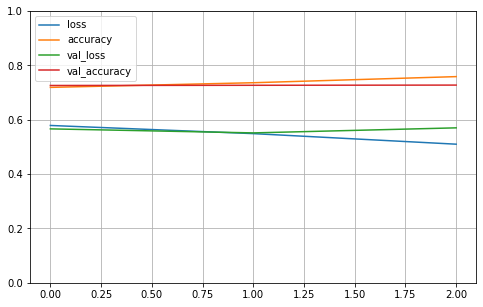

Compute valiation accuracy
2023-01-17 16:13:31.800147
Range of scores: 0.13349439 to 0.97391087
Predicted zeros and ones 137 1257
Accuracy: 72.74% Precision: 75.02% Recall: 93.46% F1: 83.23%
2023-01-17 16:13:36.838046
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (5744, 3997) (5744, 1)
Valid sizes (1304, 3997) (1304, 1)
Train set ones/size 4030 / 5744
Valid set ones/size 983 / 1304
BUILD MODEL
COMPILE
FIT
2023-01-17 16:13:38.934390
Epoch 1/3
180/180 [==============================] - 45s 230ms/step - loss: 0.5747 - accuracy: 0.7131 - val_loss: 0.5340 - val_accuracy: 0.7431
Epoch 2/3
180/180 [==============================] - 41s 226ms/step - loss: 0.5343 - accuracy: 0.7463 - val_loss: 0.5677 - val_accuracy: 0.7055
Epoch 3/3
180/180 [==============================] - 41s 227ms/step - loss: 0.4756 - accuracy: 0.7779 - val_loss: 0.5846 - val_accuracy: 0.6840


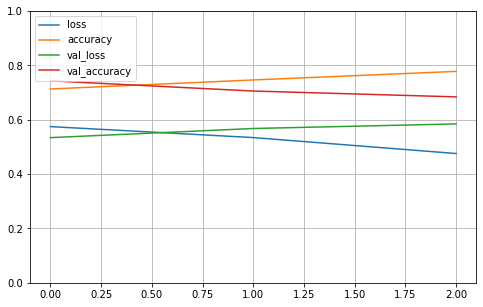

Compute valiation accuracy
2023-01-17 16:16:04.224603
Range of scores: 0.07867633 to 0.9924907
Predicted zeros and ones 253 1051
Accuracy: 68.40% Precision: 77.16% Recall: 82.50% F1: 79.74%
2023-01-17 16:16:08.933538
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (5628, 3997) (5628, 1)
Valid sizes (1420, 3997) (1420, 1)
Train set ones/size 4004 / 5628
Valid set ones/size 1009 / 1420
BUILD MODEL
COMPILE
FIT
2023-01-17 16:16:11.014482
Epoch 1/3
176/176 [==============================] - 45s 237ms/step - loss: 0.5711 - accuracy: 0.7230 - val_loss: 0.5669 - val_accuracy: 0.7007
Epoch 2/3
176/176 [==============================] - 41s 230ms/step - loss: 0.5408 - accuracy: 0.7425 - val_loss: 0.5732 - val_accuracy: 0.7092
Epoch 3/3
176/176 [==============================] - 40s 228ms/step - loss: 0.4946 - accuracy: 0.7672 - val_loss: 0.6096 - val_accuracy: 0.6866


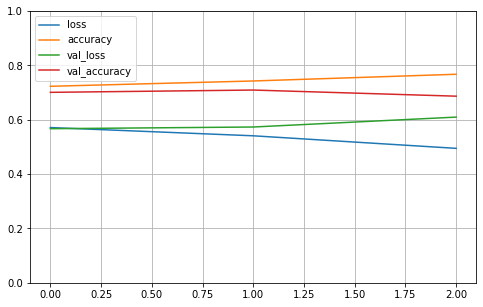

Compute valiation accuracy
2023-01-17 16:18:35.976078
Range of scores: 0.109276116 to 0.9848726
Predicted zeros and ones 186 1234
Accuracy: 68.66% Precision: 72.85% Recall: 89.10% F1: 80.16%
2023-01-17 16:18:41.006553
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (5590, 3997) (5590, 1)
Valid sizes (1458, 3997) (1458, 1)
Train set ones/size 3949 / 5590
Valid set ones/size 1064 / 1458
BUILD MODEL
COMPILE
FIT
2023-01-17 16:18:43.089957
Epoch 1/3
175/175 [==============================] - 45s 235ms/step - loss: 0.5794 - accuracy: 0.7100 - val_loss: 0.5511 - val_accuracy: 0.7462
Epoch 2/3
175/175 [==============================] - 40s 230ms/step - loss: 0.5386 - accuracy: 0.7419 - val_loss: 0.5719 - val_accuracy: 0.7133
Epoch 3/3
175/175 [==============================] - 40s 229ms/step - loss: 0.5006 - accuracy: 0.7639 - val_loss: 0.5771 - val_accuracy: 0.7428


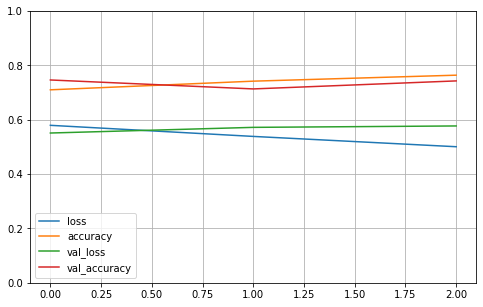

Compute valiation accuracy
2023-01-17 16:21:08.751674
Range of scores: 0.120981015 to 0.99033654
Predicted zeros and ones 135 1323
Accuracy: 74.28% Precision: 76.04% Recall: 94.55% F1: 84.29%
2023-01-17 16:21:14.551121
Fold 5
Training example
[ 34 135  26 ...   0   0   0]
Train sizes (5576, 3997) (5576, 1)
Valid sizes (1472, 3997) (1472, 1)
Train set ones/size 4065 / 5576
Valid set ones/size 948 / 1472
BUILD MODEL
COMPILE
FIT
2023-01-17 16:21:16.648296
Epoch 1/3
175/175 [==============================] - 44s 233ms/step - loss: 0.5673 - accuracy: 0.7278 - val_loss: 0.5904 - val_accuracy: 0.7024
Epoch 2/3
175/175 [==============================] - 41s 237ms/step - loss: 0.5303 - accuracy: 0.7428 - val_loss: 0.6127 - val_accuracy: 0.6909
Epoch 3/3
175/175 [==============================] - 40s 230ms/step - loss: 0.4912 - accuracy: 0.7678 - val_loss: 0.6123 - val_accuracy: 0.6800


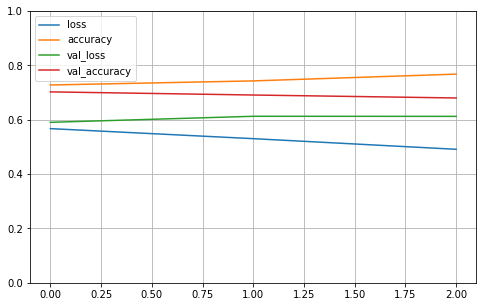

Compute valiation accuracy
2023-01-17 16:23:22.479139
Range of scores: 0.12905416 to 0.9887918
Predicted zeros and ones 257 1215
Accuracy: 68.00% Precision: 69.63% Recall: 89.24% F1: 78.22%
2023-01-17 16:23:28.211982

Cross validation 5 folds 3 epochs
 accuracy mean 70.42% +/- 2.58
 precision mean 74.14% +/- 2.67
 recall mean 89.77% +/- 4.24
 F1 mean 81.13% +/- 2.27
2023-01-17 16:23:28.214278


In [51]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())